In [1]:
#!pip install shap
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%config InlineBacked.figure_format = 'svg'
plt.style.use('seaborn')

# Class Models



In [3]:
class SimpleLogisticRegression():

  def __init__(self, thresh=0.5):
    self.thresh = thresh
    self.W = None
    self.B = None

  def fit(self, X, y, eta=1e-3, epochs=1e3, show_curve=False):

    epochs=int(epochs)   #make sure it is an integer
    N,D = X.shape

    #Initialize Weights and Bias
    self.W = np.random.randn(D)
    self.B = np.random.randn(1)

    J = np.zeros(epochs)

    for epoch in range(epochs):

      p_hat = self.__forward__(X)
      J[epoch] = bin_cross_entropy(y, p_hat)

      # Weight and Bias Updates
      self.W -= eta*(1/N)*X.T@(p_hat - y)
      self.B -= eta*(1/N)*np.sum(p_hat - y)
    
    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel('epochs')
      plt.ylabel('$\mathcal{J}$')
      plt.title('Training Curve')

  def __forward__(self, X):
    return sigmoid(X@self.W + self.B)

  def predict(self, X):
    return (self.__forward__(X) >= self.thresh).astype(np.int32)


class ANN():
  def __init__(self,architecture,activations = None, mode=0):

    self.mode = mode
    self.architecture = architecture
    self.activations = activations
    self.L = len(architecture)+1

  def fit(self, X, y,eta=1e-3, epochs=1e3,show_curve=False):

    epochs = int(epochs)
    if self.mode:
      Y=y
    else:
      Y = one_hot_encode(y)
    N,D = X.shape
    K = Y.shape[1]
    #Initialize Weights and Biases
    self.W ={l: np.random.randn(M[0],M[1]) for l,M in
            enumerate(zip(([D]+self.architecture),(self.architecture+[K])),1)}
    self.b = {l:np.random.randn(M) for l, M in enumerate(self.architecture+[K],1)}

    ## Activation Function Loading
    if self.activations is None:
      self.a ={l:ReLU for l in range(1,self.L)}
    else:
      self.a ={l:act for l,act in enumerate(self.activations,1)}
    # Set Mode
    if self.mode:
      self.a[self.L] = linear
    else:
      self.a[self.L] = softmax
    
    J = np.zeros(epochs)

    for epoch in range(epochs):

      self.__forward__(X)

      if self.mode:
        J[epoch] = OLS(Y,self.Z[self.L])
      else:
        J[epoch] = cross_entropy(Y,self.Z[self.L])

      dH =(1/N) *(self.Z[self.L]-Y)

      for l in sorted(self.W.keys(), reverse=True):
        dW = self.Z[l-1].T@dH
        db = dH.sum(axis=0)
        # Weights and bias update rule
        self.W[l] -= eta*dW
        self.b[l] -= eta*db
        if l>1:
          dZ = dH@self.W[l].T
          dH = dZ * derivative(self.Z[l-1],self.a[l-1])
    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel('epochs')
      plt.ylabel('$\mathcal{J}$')
      plt.title('Training curve')
      plt.show()
  def __forward__(self,X):
    self.Z = {0:X}

    for l in sorted (self.W.keys()):
      self.Z[l] = self.a[l](self.Z[l-1]@self.W[l]+self.b[l])
  
  def predict (self,X):
    self.__forward__(X)

    if self.mode:
      return self.Z[self.L]
    else:
      return self.Z[self.L].argmax(axis=1)


# Useful Function

In [4]:
def bin_cross_entropy(y,p_hat):
  return (-1/len(y))*np.sum(y*np.log(p_hat)+(1-y)*np.log(1-p_hat))

def accuracy(y,y_hat):
  return np.mean(y==y_hat)

def cross_entropy(Y,P_hat):
  return -(1/len(Y))*np.sum(np.sum(Y*np.log(P_hat),axis=1),axis=0)

def OLS(Y,Y_hat):
  return (1/(2*len(Y)))*np.sum((Y-Y_hat)**2)

def indices_to_one_hot(data,nb_classes):
  targets = np.array(data).reshape(-1)
  return np.eye(nb_classes)[targets]

def one_hot_encode(y):
  N=len(y)
  K=len(set(y))

  Y = np.zeros((N,K))
  for i in range(N):
    Y[i,y[i]]=1
  return Y

def derivative(Z,a):

  if a == linear:
    return 1
  
  elif a == sigmoid:
    return Z*(1-Z)

  elif a == ReLU:
    return (Z>0).astype(int)

  elif a == np.tanh:
    return 1-Z*Z

  else:
    ValueError('Unknown Activation Function')

def one_hot_encoding(data, column):

  unique_values = data[column].unique()
  data[unique_values] = 0

  for x in unique_values:
    data[x] = np.where(data[column] == x, 1, 0)
  
  return data.drop(column, inplace = True, axis = 1)

def minmax_norm(data, train):
  min = np.amin(train,axis=0)
  max = np.amax(train,axis=0)
  return (data - min)/(max-min)

def metrics(CM):
  results = {'precision' : round(CM.loc[1,1]/(CM.loc[1,1]+CM.loc[0,1]),3),
              'recall' : round(CM.loc[1,1]/(CM.loc[1,1]+CM.loc[1,0]),3),
              'accuracy' : round((CM.loc[0,0] + CM.loc[1,1])/CM.sum().sum(),3),
              'F1' : round(CM.loc[1,1]/(CM.loc[1,1] + 0.5 * (CM.loc[0,1] + CM.loc[1,0])),3) }
  return results


# Activation Functions

In [5]:
def sigmoid(h):
  return 1/(1+np.exp(-h))

def ReLU(H):
  return H*(H>0)

def softmax(H):
  eH = np.exp(H)
  return eH/eH.sum(axis=1,keepdims=True)

def linear(H):
  return H

# Introduction

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Datos/Churn_Modelling.csv', index_col = 0)

In [7]:
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [8]:
# Dropping customer id
df.drop(['CustomerId','Surname'], inplace = True, axis = 1)

In [9]:
# Looking for missing values
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
# Type of data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


# EDA: Exploratory Data Analysis

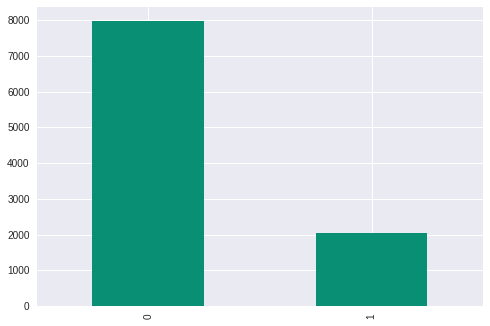

In [11]:
df.Exited.value_counts().plot.bar(color = '#088F74')

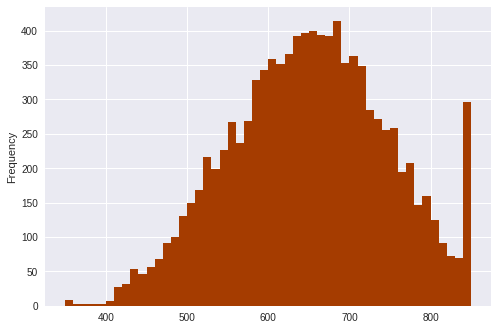

In [12]:
df.CreditScore.plot.hist(bins = 50, color = '#A53C00')

In [13]:
df.CreditScore.describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

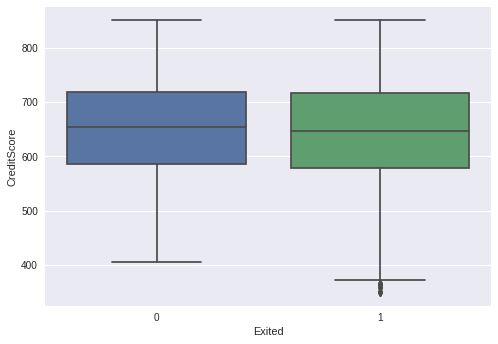

In [14]:
sns.boxplot(x=df.Exited, y=df.CreditScore)

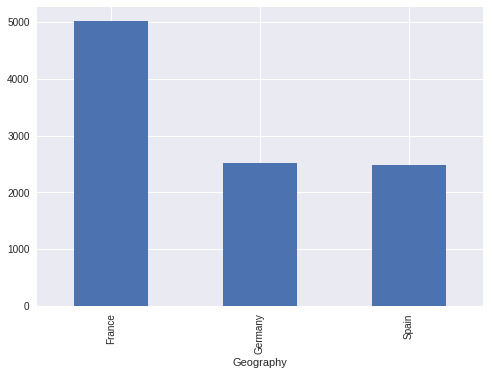

In [15]:
df.groupby('Geography').size().plot.bar()

In [16]:
 df.groupby('Geography')['Exited'].value_counts()

Geography  Exited
France     0         4204
           1          810
Germany    0         1695
           1          814
Spain      0         2064
           1          413
Name: Exited, dtype: int64

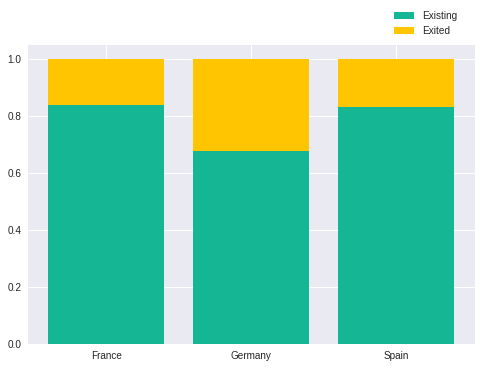

In [17]:
Exited_yes =[4204/(4204+810),1695/(1695+814), 2064/(2064+413)]
Exited_no =[810/(4204+810), 814/(1695+814), 413/(2064+413)]

Exited = ["France","Germany","Spain"]

plt.bar(Exited,Exited_yes, color = "#14B694", label = "Existing")
plt.bar(Exited,Exited_no, color = "#FFC500", bottom = np.array(Exited_yes), label = "Exited")

plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.show()

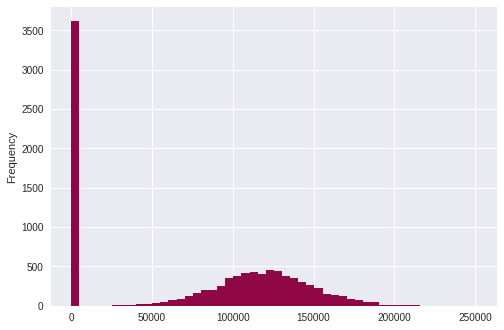

In [18]:
df.Balance.plot.hist(bins = 50, color = '#8F0845')

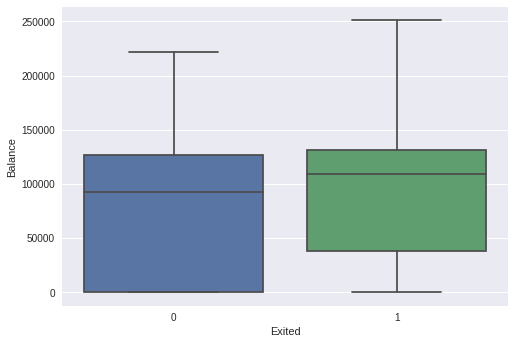

In [19]:
sns.boxplot(x=df.Exited, y=df.Balance)

In [20]:
 df.groupby('Gender')['Exited'].value_counts()

Gender  Exited
Female  0         3404
        1         1139
Male    0         4559
        1          898
Name: Exited, dtype: int64

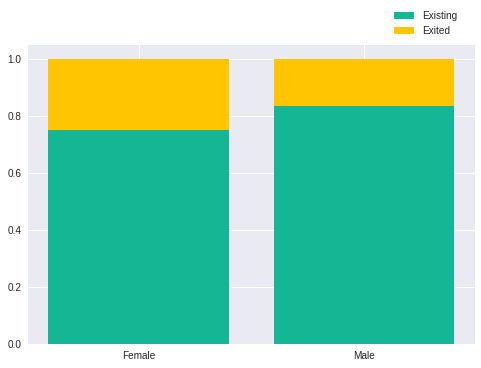

In [21]:
Exited_yes =[1139/(1139+3404),898/(898+4559)]
Exited_no =[3404/(1139+3404), 4559/(898+4559)]

Exited = ["Female","Male"]

plt.bar(Exited,Exited_no, color = "#14B694", label = "Existing")
plt.bar(Exited,Exited_yes, color = "#FFC500", bottom = np.array(Exited_no), label = "Exited")

plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.show()

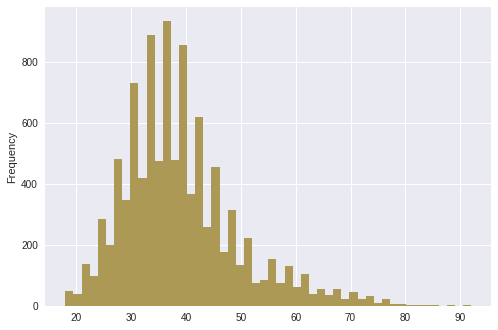

In [22]:
df.Age.plot.hist(bins = 50, color = '#AD9956')

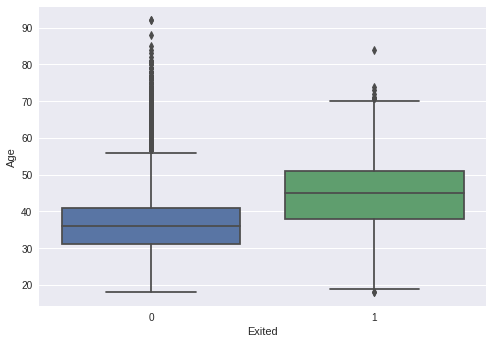

In [23]:
sns.boxplot(x=df.Exited, y=df.Age)

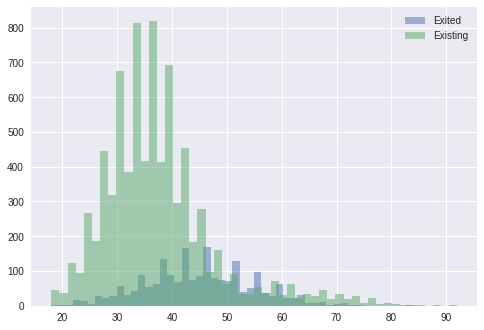

In [24]:
plt.hist(x = df[df['Exited']== 1].Age , bins = 50, label = 'Exited', alpha = 0.5)
plt.hist(x = df[df['Exited']== 0].Age , bins = 50, label = 'Existing', alpha = 0.5)
plt.legend()

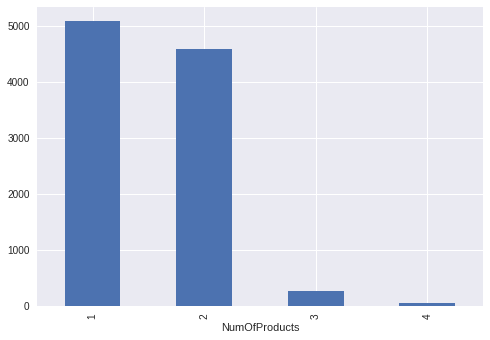

In [25]:
df.groupby('NumOfProducts').size().plot.bar()

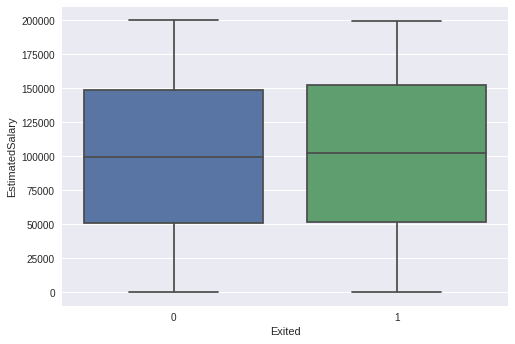

In [26]:
sns.boxplot(x=df.Exited, y=df.EstimatedSalary)

In [27]:
 df.groupby('HasCrCard')['Exited'].value_counts()

HasCrCard  Exited
0          0         2332
           1          613
1          0         5631
           1         1424
Name: Exited, dtype: int64

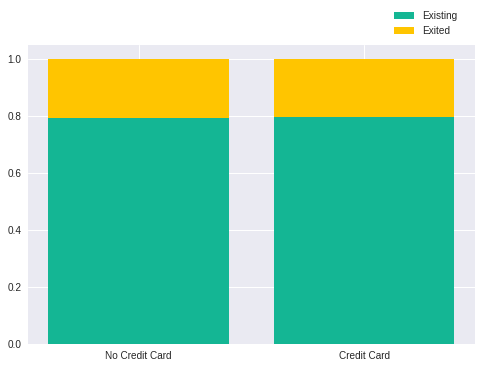

In [28]:
Exited_yes =[613/(2332+613),1424/(1424+5631)]
Exited_no =[2332/(2332+613),5631/(1424+5631)]

Exited = ["No Credit Card","Credit Card"]

plt.bar(Exited,Exited_no, color = "#14B694", label = "Existing")
plt.bar(Exited,Exited_yes, color = "#FFC500", bottom = np.array(Exited_no), label = "Exited")

plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.show()

In [29]:
df.groupby('IsActiveMember')['Exited'].value_counts()

IsActiveMember  Exited
0               0         3547
                1         1302
1               0         4416
                1          735
Name: Exited, dtype: int64

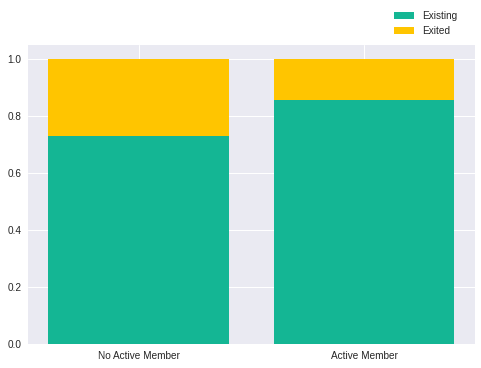

In [30]:
Exited_yes =[1302/(3547+1302),735/(735+4416)]
Exited_no =[3547/(3547+1302),4416/(735+4416)]

Exited = ["No Active Member","Active Member"]

plt.bar(Exited,Exited_no, color = "#14B694", label = "Existing")
plt.bar(Exited,Exited_yes, color = "#FFC500", bottom = np.array(Exited_no), label = "Exited")

plt.legend(loc="lower left",bbox_to_anchor=(0.8,1.0))
plt.show()

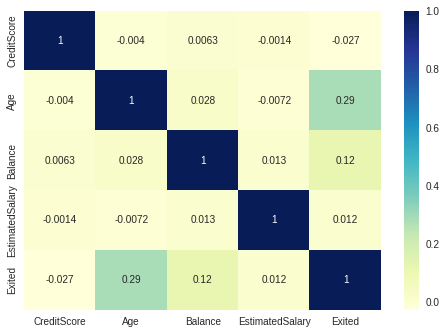

In [31]:
cm = df[['CreditScore','Age', 'Balance','EstimatedSalary','Exited']].corr()
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu')

In [32]:
one_hot_encoding(df, 'Geography')
df['Gender'] = np.where(df['Gender'] == 'Female', 1, 0)
df['NoMoney'] = np.where(df['Balance'] == 0, 1, 0)
df

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Spain,Germany,NoMoney
RowNumber,,,,,,,,,,,,,,
1,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0,1
2,608,1,41,1,83807.86,1,0,1,112542.58,0,0,1,0,0
3,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0,0
4,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0,1
5,850,1,43,2,125510.82,1,1,1,79084.10,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,771,0,39,5,0.00,2,1,0,96270.64,0,1,0,0,1
9997,516,0,35,10,57369.61,1,1,1,101699.77,0,1,0,0,0
9998,709,1,36,7,0.00,1,0,1,42085.58,1,1,0,0,1


In [33]:
## Split database
i = np.arange(len(df))
np.random.seed(1)
np.random.shuffle(i)
train = df.iloc[i[:int(len(df)*0.85)]]
test = df.iloc[i[int(len(df)*0.85):]]

In [34]:
# Changing the DataFrame into numpy array
X_train = train.loc[:, train.columns != 'Exited'].to_numpy()
y_train = train.Exited.to_numpy()
X_test = test.loc[:, test.columns != 'Exited'].to_numpy()
y_test = test.Exited.to_numpy()

# Data Normalization
X_test = minmax_norm(X_test, X_train)
X_train = minmax_norm(X_train,X_train)

# Model 1: Logistic Regression

Training Accuracy: 0.7989


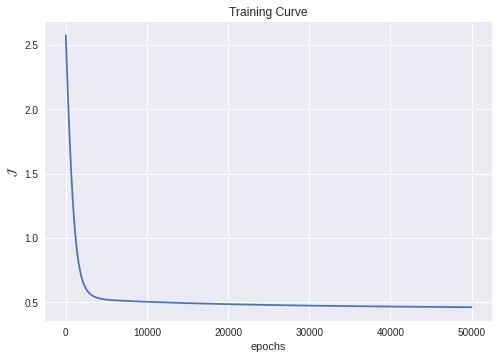

In [35]:
log_reg = SimpleLogisticRegression()
log_reg.fit(X_train, y_train, eta = 1e-3, epochs = 5e4, show_curve=True)
y_hat = log_reg.predict(X_train)

print(f'Training Accuracy: {accuracy(y_train, y_hat):0.4f}')

In [36]:
y_test_lr = log_reg.predict(X_test)
print(f'Test Accuracy: {accuracy(y_test,y_test_lr):0.4f}')

Test Accuracy: 0.8020


Text(0.5, 14.5, 'Predicted label')

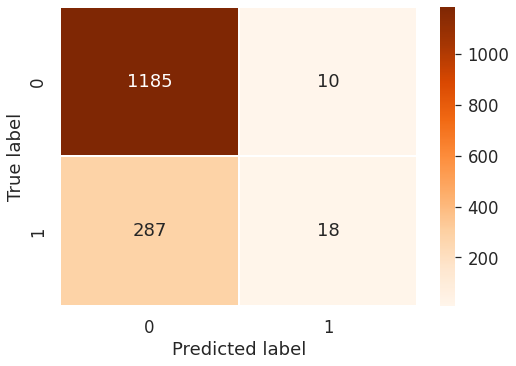

In [37]:
cm = pd.crosstab(y_test, y_test_lr)
sns.set(font_scale = 1.5)
ax = sns.heatmap(cm, annot=True, cmap='Oranges',  fmt='d', linewidths=1)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [38]:
pd.DataFrame([metrics(cm)])

,precision,recall,accuracy,F1
0,0.643,0.059,0.802,0.108


# Model 2: Neural Network


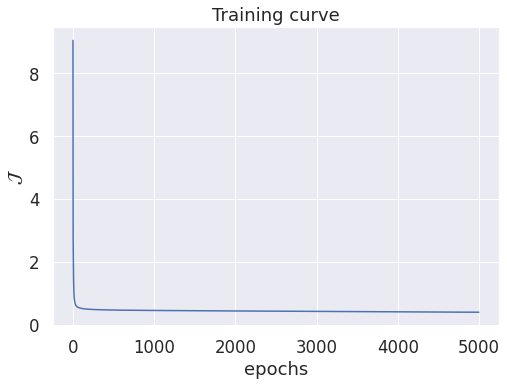

Training Accuracy: 0.8328


In [43]:
ann = ANN([12,10,8],[ReLU, ReLU, ReLU])
ann.fit(X_train, y_train, epochs = 5000, eta = 3e-2, show_curve = True)
y_train_ann = ann.predict(X_train)
print(f'Training Accuracy: {accuracy(y_train,y_train_ann):0.4f}')

In [44]:
y_test_ann = ann.predict(X_test)
print(f'Test Accuracy: {accuracy(y_test, y_test_ann):0.4f}')

Test Accuracy: 0.8220


Text(0.5, 14.5, 'Predicted label')

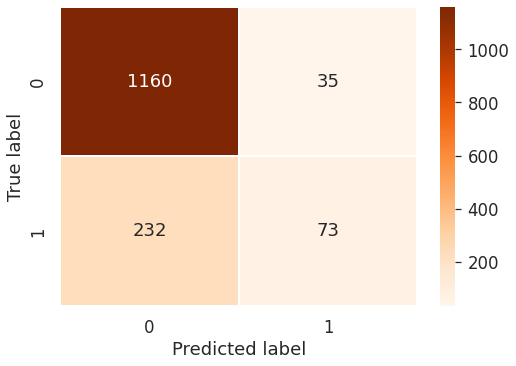

In [45]:
cm2 = pd.crosstab(y_test, y_test_ann)
sns.set(font_scale = 1.5)
ax = sns.heatmap(cm2, annot=True, cmap='Oranges',  fmt='d', linewidths=1)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [46]:
pd.DataFrame([metrics(cm2)])

,precision,recall,accuracy,F1
0,0.676,0.239,0.822,0.354


# Results
Neural Networks had a better performance than linear regression. In this case, second model is chosen.

In [72]:
f = lambda x: ann.predict(x)
med = np.median(X_train, axis = 0).reshape(1, X_train.shape[1])

explainer = shap.Explainer(f, med, 
          feature_names = ['CreditScore','Gender','Age','Tenure','Balance','NumOfProducts', 
                           'HasCrCard','IsActiveMember','EstimatedSalary','France','Spain','Germany','NoMoney'])
shap_values = explainer(X_test)

Permutation explainer: 1501it [00:21, 37.97it/s]                          


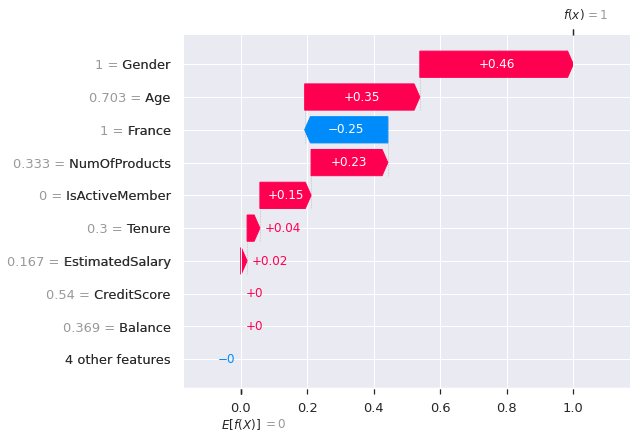

In [77]:
sns.set(font_scale = 1)
shap.plots.waterfall(shap_values[1])

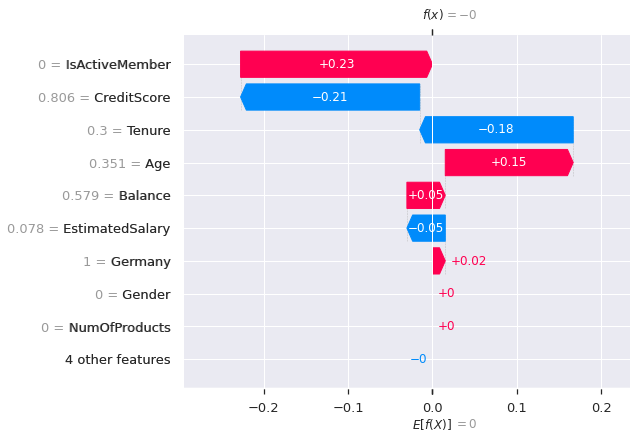

In [89]:
sns.set(font_scale = 1)
shap.plots.waterfall(shap_values[14])

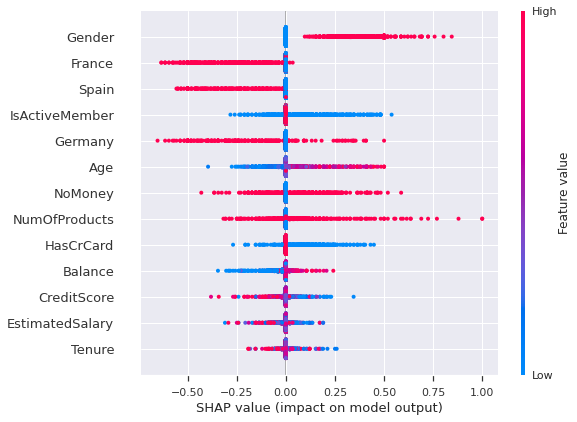

In [74]:
shap.plots.beeswarm(shap_values, max_display=14)

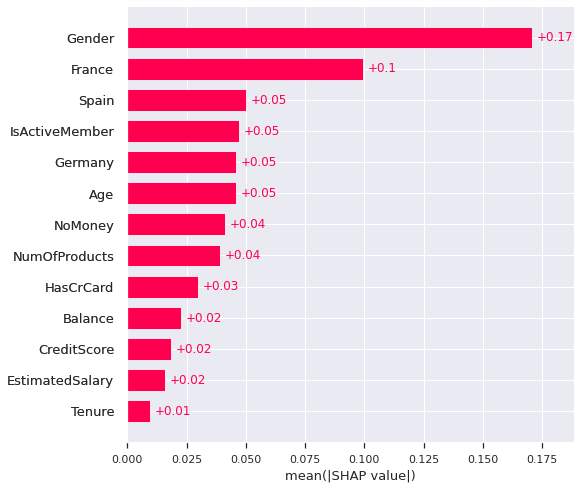

In [75]:
shap.plots.bar(shap_values, max_display=13)